In [14]:
import logging
from io import BytesIO
from typing import Annotated, Literal

# from langchain_anthropic import ChatAnthropic
# from langchain_ollama.chat_models import ChatOllama

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from PIL import Image
from typing_extensions import TypedDict

from dotenv import load_dotenv
from retriever_tool import index_files
from save_file import save_csv_file
# from .arxiv import arxiv_search
# from .latex import render_latex_pdf
# from .pdf import read_pdf

load_dotenv()

# Setup module logger
logger = logging.getLogger(__name__)

INITIAL_PROMPT = """
You are a professional equity research analyst. Analyze the stock by a given stock name or code based on its latest quarterly earnings, valuation metrics (P/E, P/S, EV/EBITDA), competitive positioning, and current macroeconomic trends. Include the following in your report:

1. Company Overview – brief business summary and key revenue streams

2. Recent Financial Performance – revenue, EPS, margins (QoQ and YoY)

3. Valuation Comparison 

4. Technical Analysis – key support/resistance levels, moving averages

5. Catalysts & Risks – what might drive the stock price up or down in the next 6–12 months

6. Buy/Hold/Sell Recommendation – with a price target and rationale

Use up-to-date data and keep the tone professional and concise. Format your answer as a short research note.

Firstly, check if there are any PDF files under data_sources directory, if there are files, use them as data source of the answer.

Then, ask me to input desired stock name or code to get analysis from

Then convert the response into a csv format with the following data as headers, wrapped with double quote

Date, stock name/code, company overview, recent financials, valuation metrics, technical analysis, cataysts, risks, recommendation

Start a new line, followed by field data, use double quote for fields and comma for separator.
Please use the query date as Date field, date format is YYYY-MM-DD, for example, 2025-12-30

Finally, ask me if I want to write the content into a file
"""


class State(TypedDict):
    messages: Annotated[list, add_messages]


def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        logger.info(f"Message received: {message.content[:200]}...")
        message.pretty_print()


def run_workflow():
    logger.info("Initializing workflow")

    tools = [index_files, save_csv_file]
    tool_node = ToolNode(tools)

    model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)
    # model = ChatAnthropic(model="claude-3-5-sonnet-20241022").bind_tools(tools)
    # model = ChatOllama(model="llama3-groq-tool-use:8b").bind_tools(tools)

    logger.info(f"Initialized model and loaded {len(tools)} tools")

    # Define the function that determines whether to continue or not
    def should_continue(state: State) -> Literal["tools", END]:
        messages = state["messages"]
        last_message = messages[-1]
        if last_message.tool_calls:
            return "tools"
        return END

    # Define the function that calls the model
    def call_model(state: State):
        messages = state["messages"]
        response = model.invoke(messages)
        return {"messages": [response]}

    config = {"configurable": {"thread_id": 1}}
    logger.info(f"Set configuration: {config}")

    workflow = StateGraph(State)
    workflow.add_node("agent", call_model)
    workflow.add_node("tools", tool_node)
    workflow.add_edge(START, "agent")
    workflow.add_conditional_edges("agent", should_continue)
    workflow.add_edge("tools", "agent")

    checkpointer = MemorySaver()
    graph = workflow.compile(checkpointer=checkpointer)
    return graph
    # Image.open(BytesIO(graph.get_graph().draw_mermaid_png())).show()

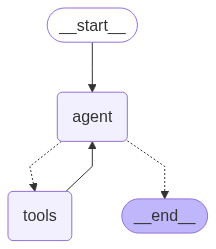

In [16]:
from IPython.display import Image, display

graph = run_workflow()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass